In [133]:
import pandas as pd
from langdetect import detect
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import CountVectorizer
import math
import matplotlib.pyplot as plt

In [90]:
lem = WordNetLemmatizer() #create lemmatizer

In [91]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kseniapavlina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [92]:
dictionary = pd.read_csv('../data/processedDict.csv')
dictionary

,word,cat_lev1,cat_lev2,cat_lev3,ndf
0,information,business,professional_conduct_host,advice,0.008904
1,recommendations,business,professional_conduct_host,advice,0.008375
2,tips,business,professional_conduct_host,advice,0.008399
3,advice,business,professional_conduct_host,advice,0.007568
4,suggestions,business,professional_conduct_host,advice,0.007580
...,...,...,...,...,...
347,talking,social,social_interaction,talking,0.001961
348,chatting,social,social_interaction,talking,0.001408
349,moments,social,social_interaction,talking,0.001155
350,chats,social,social_interaction,talking,0.000553


In [93]:
dictionary['word'] = dictionary['word'].apply(lambda x: lem.lemmatize(x, pos='n'))

In [94]:
filepath = '../data/en_reviews/belize_en.csv'
reviews = pd.read_csv(filepath)

# reviews = reviews['date']
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion
0,36666,145174,27/11/2010,278365,Rb,Monique and Maurice has put Caye Caulker at th...,en,0.039581
1,36666,167715,08/01/2011,258142,Angellini,"We had the best time, food and conversations w...",en,0.031722
2,36666,172375,19/01/2011,268097,Michael,"Great, great place to stay on Caye Caulker. Ve...",en,0.037152
3,36666,179895,08/02/2011,340713,Melinda,We stayed with Monique and Maurice for a coupl...,en,0.046602
4,36666,181056,12/02/2011,117024,Gail,Monique's guest house was great for us. It was...,en,0.055441
...,...,...,...,...,...,...,...,...
37705,39127463,557741654,01/11/2019,22844580,Cheryl,"Very clean, new place. There are 2 units, we ...",en,0.064935
37706,39183755,550911001,19/10/2019,41897670,Alice,Brandon’s room at Caye caulker is basic but co...,en,0.048851
37707,39183755,562960822,11/11/2019,23535832,Clara,Great spot! Loved having AC and a pool! \nBage...,en,0.025641
37708,39944342,565690422,17/11/2019,25461269,Moira,Great place!,en,0.090909


In [95]:
table = str.maketrans('', '', string.punctuation) #mapping to strip punctuation in review

In [96]:
#strip punct of each review -> lemmatise -> output is list of words so join into sentences
reviews['comments'] = reviews.comments.apply(lambda review: ' '.join(map(str, [lem.lemmatize(word.translate(table), pos='n') for word in review.lower().split()])))
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion
0,36666,145174,27/11/2010,278365,Rb,monique and maurice ha put caye caulker at the...,en,0.039581
1,36666,167715,08/01/2011,258142,Angellini,we had the best time food and conversation whi...,en,0.031722
2,36666,172375,19/01/2011,268097,Michael,great great place to stay on caye caulker very...,en,0.037152
3,36666,179895,08/02/2011,340713,Melinda,we stayed with monique and maurice for a coupl...,en,0.046602
4,36666,181056,12/02/2011,117024,Gail,moniques guest house wa great for u it wa exac...,en,0.055441
...,...,...,...,...,...,...,...,...
37705,39127463,557741654,01/11/2019,22844580,Cheryl,very clean new place there are 2 unit we were ...,en,0.064935
37706,39183755,550911001,19/10/2019,41897670,Alice,brandon’s room at caye caulker is basic but co...,en,0.048851
37707,39183755,562960822,11/11/2019,23535832,Clara,great spot loved having ac and a pool bagel in...,en,0.025641
37708,39944342,565690422,17/11/2019,25461269,Moira,great place,en,0.090909


In [110]:
d = {'year': [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], 'meal':0, 'people':0, 'personality_host':0, 'sharing':0, 'talking':0}
social_out = pd.DataFrame(data=d)
social_out

,year,meal,people,personality_host,sharing,talking
0,2010,0,0,0,0,0
1,2011,0,0,0,0,0
2,2012,0,0,0,0,0
3,2013,0,0,0,0,0
4,2014,0,0,0,0,0
5,2015,0,0,0,0,0
6,2016,0,0,0,0,0
7,2017,0,0,0,0,0
8,2018,0,0,0,0,0
9,2019,0,0,0,0,0


In [111]:
def logTermFrequency(word, review):
    totalNumberOfWords = review.split()
    totalNumberOfWords = len(totalNumberOfWords)
    numberOfWord = review.count(word)
    if numberOfWord == 0:
        return 0;
    result = numberOfWord * 100/ totalNumberOfWords
    return result   

In [112]:
def adoptionForOneReview(category, review, dictionary):
    adoption = 0
    dictionaryWords = dictionary[(dictionary['cat_lev3'] == category)]
    dictionaryWords = dictionaryWords['word']
    for word in dictionaryWords:
        adoption = adoption + logTermFrequency(word, review)
    return adoption

In [114]:
# reviews['business'] = reviews['comments'].apply(lambda x: adoptionForOneReview('business', x, dictionary))
# reviews['social'] = reviews['comments'].apply(lambda x: adoptionForOneReview('social', x, dictionary))
reviews['meal'] = reviews['comments'].apply(lambda x: adoptionForOneReview('meal', x, dictionary))
reviews['people'] = reviews['comments'].apply(lambda x: adoptionForOneReview('people', x, dictionary))
reviews['personality_host'] = reviews['comments'].apply(lambda x: adoptionForOneReview('personality_host', x, dictionary))
reviews['sharing'] = reviews['comments'].apply(lambda x: adoptionForOneReview('sharing', x, dictionary))
reviews['talking'] = reviews['comments'].apply(lambda x: adoptionForOneReview('talking', x, dictionary))
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion,business,social,meal,people,personality_host,sharing,talking
0,36666,145174,2010-11-27,278365,Rb,monique and maurice ha put caye caulker at the...,en,0.039581,8.860759,15.822785,0.632911,13.924051,0.632911,0.0,0.632911
1,36666,167715,2011-08-01,258142,Angellini,we had the best time food and conversation whi...,en,0.031722,10.000000,14.545455,0.000000,10.909091,1.818182,0.0,3.636364
2,36666,172375,2011-01-19,268097,Michael,great great place to stay on caye caulker very...,en,0.037152,7.812500,14.062500,0.000000,14.062500,0.000000,0.0,0.000000
3,36666,179895,2011-08-02,340713,Melinda,we stayed with monique and maurice for a coupl...,en,0.046602,14.705882,16.666667,0.000000,16.666667,1.960784,0.0,0.000000
4,36666,181056,2011-12-02,117024,Gail,moniques guest house wa great for u it wa exac...,en,0.055441,15.957447,20.212766,1.063830,17.021277,4.255319,0.0,1.063830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37705,39127463,557741654,2019-01-11,22844580,Cheryl,very clean new place there are 2 unit we were ...,en,0.064935,27.272727,18.181818,0.000000,15.909091,2.272727,0.0,0.000000
37706,39183755,550911001,2019-10-19,41897670,Alice,brandon’s room at caye caulker is basic but co...,en,0.048851,16.417910,19.402985,2.985075,14.925373,4.477612,0.0,0.000000
37707,39183755,562960822,2019-11-11,23535832,Clara,great spot loved having ac and a pool bagel in...,en,0.025641,9.090909,4.545455,0.000000,4.545455,0.000000,0.0,0.000000
37708,39944342,565690422,2019-11-17,25461269,Moira,great place,en,0.090909,50.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [123]:
k_meal = reviews['meal'].loc[reviews['meal'] > 0]
k_people = reviews['people'].loc[reviews['people'] > 0]
k_personality_host = reviews['personality_host'].loc[reviews['personality_host'] > 0]
k_sharing = reviews['sharing'].loc[reviews['sharing'] > 0]
k_talking = reviews['talking'].loc[reviews['talking'] > 0]
k_meal = k_meal.min()
k_people = k_people.min()
k_personality_host = k_personality_host.min()
k_sharing = k_sharing.min()
k_talking = k_talking.min()
print(k_meal)
print(k_people)
print(k_personality_host)
print(k_sharing)
print(k_talking)

0.12254901960784313
1.2195121951219512
0.13386880856760375
0.10020040080160321
0.13793103448275862


In [101]:
# k_business = reviews['business'].loc[reviews['business'] > 0]
# k_business = k_business.min()
# k_business

1.0309278350515463

In [102]:
reviews['date'] = pd.to_datetime(reviews['date'])

In [103]:
def adoptionForSetOfReviews(category, setOfReviews, dictionary, startDate, endDate, k):
    adoption = 1
    mask = (setOfReviews['date'] > startDate) & (setOfReviews['date'] < endDate)
    setOfReviews = setOfReviews.loc[mask]
    setOfReviews = setOfReviews[category]
    numOfReviews = len(setOfReviews)
    for review in setOfReviews:
        adoption *= (review + k)**(1 / numOfReviews)
    adoption = adoption - k
    return adoption

In [124]:
mask = (reviews['date'] > '2011-01-01') & (reviews['date'] < '2012-01-01')
setOfReviews = reviews.loc[mask]
setOfReviews

,listing_id,id,date,reviewer_id,reviewer_name,comments,langs,dict_proportion,business,social,meal,people,personality_host,sharing,talking
1,36666,167715,2011-08-01,258142,Angellini,we had the best time food and conversation whi...,en,0.031722,10.000000,14.545455,0.000000,10.909091,1.818182,0.000000,3.636364
2,36666,172375,2011-01-19,268097,Michael,great great place to stay on caye caulker very...,en,0.037152,7.812500,14.062500,0.000000,14.062500,0.000000,0.000000,0.000000
3,36666,179895,2011-08-02,340713,Melinda,we stayed with monique and maurice for a coupl...,en,0.046602,14.705882,16.666667,0.000000,16.666667,1.960784,0.000000,0.000000
4,36666,181056,2011-12-02,117024,Gail,moniques guest house wa great for u it wa exac...,en,0.055441,15.957447,20.212766,1.063830,17.021277,4.255319,0.000000,1.063830
5,36666,213948,2011-03-31,352643,John,very enjoyable accommodation in a splendidly r...,en,0.012048,0.000000,6.666667,0.000000,3.333333,3.333333,0.000000,0.000000
6,36666,284556,2011-05-28,460817,Lauren,our host monique and maurice were very friendl...,en,0.047486,6.756757,21.621622,0.000000,20.270270,1.351351,0.000000,0.000000
7,36666,299253,2011-06-06,373646,Jonathan,me and my new wife stayed at the caribbean gue...,en,0.041262,10.000000,11.250000,0.000000,11.250000,1.250000,0.000000,0.000000
8,36666,343979,2011-06-30,476448,Heather,monique is a fantastic host and the house is p...,en,0.041379,13.461538,9.615385,0.000000,9.615385,0.000000,0.000000,0.000000
9,36666,370677,2011-07-13,684361,Louise,word cannot describe how wonderful it wa to st...,en,0.036842,6.796117,17.475728,0.000000,12.621359,5.825243,0.970874,0.000000
10,36666,401234,2011-07-27,824570,Mike,staying with monique and willy wa an unforgett...,en,0.058824,22.641509,22.641509,1.886792,16.981132,5.660377,1.886792,0.000000


In [156]:
d = {'year': [2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012, 2012, 2012, 
              2013, 2013, 2013, 2013, 2013, 2014, 2014, 2014, 2014, 2014, 2015, 2015, 2015, 2015, 2015, 
              2016, 2016, 2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2018, 2018, 2018, 2018, 2018, 
              2019, 2019, 2019, 2019, 2019], 'sub-category' : ['meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking', 'meal', 'people', 'personality_host', 'sharing', 'talking', 
                                                          'meal', 'people', 'personality_host', 'sharing', 'talking'], 'value':0.0}
social_out = pd.DataFrame(data=d)
social_out

,year,sub-category,value
0,2010,meal,0.0
1,2010,people,0.0
2,2010,personality_host,0.0
3,2010,sharing,0.0
4,2010,talking,0.0
5,2011,meal,0.0
6,2011,people,0.0
7,2011,personality_host,0.0
8,2011,sharing,0.0
9,2011,talking,0.0


In [157]:
social_out.at[0, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2010-01-01', '2011-01-01', k_meal)
social_out.at[5, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2011-01-01', '2012-01-01', k_meal)
social_out.at[10, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2012-01-01', '2013-01-01', k_meal)
social_out.at[15, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2013-01-01', '2014-01-01', k_meal)
social_out.at[20, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2014-01-01', '2015-01-01', k_meal)
social_out.at[25, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2015-01-01', '2016-01-01', k_meal)
social_out.at[30, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2016-01-01', '2017-01-01', k_meal)
social_out.at[35, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2017-01-01', '2018-01-01', k_meal)
social_out.at[40, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2018-01-01', '2019-01-01', k_meal)
social_out.at[45, 'value'] = adoptionForSetOfReviews('meal', reviews, dictionary, '2019-01-01', '2020-01-01', k_meal)

social_out.at[1, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2010-01-01', '2011-01-01', k_people)
social_out.at[6, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2011-01-01', '2012-01-01', k_people)
social_out.at[11, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2012-01-01', '2013-01-01', k_people)
social_out.at[16, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2013-01-01', '2014-01-01', k_people)
social_out.at[21, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2014-01-01', '2015-01-01', k_people)
social_out.at[26, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2015-01-01', '2016-01-01', k_people)
social_out.at[31, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2016-01-01', '2017-01-01', k_people)
social_out.at[36, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2017-01-01', '2018-01-01', k_people)
social_out.at[41, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2018-01-01', '2019-01-01', k_people)
social_out.at[46, 'value'] = adoptionForSetOfReviews('people', reviews, dictionary, '2019-01-01', '2020-01-01', k_people)

social_out.at[2, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2010-01-01', '2011-01-01', k_personality_host)
social_out.at[7, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2011-01-01', '2012-01-01', k_personality_host)
social_out.at[12, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2012-01-01', '2013-01-01', k_personality_host)
social_out.at[17, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2013-01-01', '2014-01-01', k_personality_host)
social_out.at[22, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2014-01-01', '2015-01-01', k_personality_host)
social_out.at[27, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2015-01-01', '2016-01-01', k_personality_host)
social_out.at[32, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2016-01-01', '2017-01-01', k_personality_host)
social_out.at[37, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2017-01-01', '2018-01-01', k_personality_host)
social_out.at[42, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2018-01-01', '2019-01-01', k_personality_host)
social_out.at[47, 'value'] = adoptionForSetOfReviews('personality_host', reviews, dictionary, '2019-01-01', '2020-01-01', k_personality_host)

social_out.at[3, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2010-01-01', '2011-01-01', k_sharing)
social_out.at[8, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2011-01-01', '2012-01-01', k_sharing)
social_out.at[13, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2012-01-01', '2013-01-01', k_sharing)
social_out.at[18, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2013-01-01', '2014-01-01', k_sharing)
social_out.at[23, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2014-01-01', '2015-01-01', k_sharing)
social_out.at[28, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2015-01-01', '2016-01-01', k_sharing)
social_out.at[33, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2016-01-01', '2017-01-01', k_sharing)
social_out.at[38, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2017-01-01', '2018-01-01', k_sharing)
social_out.at[43, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2018-01-01', '2019-01-01', k_sharing)
social_out.at[48, 'value'] = adoptionForSetOfReviews('sharing', reviews, dictionary, '2019-01-01', '2020-01-01', k_sharing)

social_out.at[4, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2010-01-01', '2011-01-01', k_talking)
social_out.at[9, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2011-01-01', '2012-01-01', k_talking)
social_out.at[14, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2012-01-01', '2013-01-01', k_talking)
social_out.at[19, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2013-01-01', '2014-01-01', k_talking)
social_out.at[24, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2014-01-01', '2015-01-01', k_talking)
social_out.at[29, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2015-01-01', '2016-01-01', k_talking)
social_out.at[34, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2016-01-01', '2017-01-01', k_talking)
social_out.at[39, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2017-01-01', '2018-01-01', k_talking)
social_out.at[44, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2018-01-01', '2019-01-01', k_talking)
social_out.at[49, 'value'] = adoptionForSetOfReviews('talking', reviews, dictionary, '2019-01-01', '2020-01-01', k_talking)
# # print(adoptionForSetOfReviews('meal', reviews, dictionary, '2010-01-01', '2011-01-01', k_meal))
social_out


,year,sub-category,value
0,2010,meal,0.323354
1,2010,people,16.825227
2,2010,personality_host,0.441792
3,2010,sharing,0.000000
4,2010,talking,0.171208
5,2011,meal,0.154948
6,2011,people,11.874402
7,2011,personality_host,1.068829
8,2011,sharing,0.045076
9,2011,talking,0.037398


In [158]:
# for2010b = adoptionForSetOfReviews('business', reviews, dictionary, '2010-01-01', '2011-01-01', k_business)
# for2011b = adoptionForSetOfReviews('business', reviews, dictionary, '2011-01-01', '2012-01-01', k_business)
# for2012b = adoptionForSetOfReviews('business', reviews, dictionary, '2012-01-01', '2013-01-01', k_business)
# for2013b = adoptionForSetOfReviews('business', reviews, dictionary, '2013-01-01', '2014-01-01', k_business)
# for2014b = adoptionForSetOfReviews('business', reviews, dictionary, '2014-01-01', '2015-01-01', k_business)
# for2015b = adoptionForSetOfReviews('business', reviews, dictionary, '2015-01-01', '2016-01-01', k_business)
# for2016b = adoptionForSetOfReviews('business', reviews, dictionary, '2016-01-01', '2017-01-01', k_business)
# for2017b = adoptionForSetOfReviews('business', reviews, dictionary, '2017-01-01', '2018-01-01', k_business)
# for2018b = adoptionForSetOfReviews('business', reviews, dictionary, '2018-01-01', '2019-01-01', k_business)
# for2019b = adoptionForSetOfReviews('business', reviews, dictionary, '2019-01-01', '2020-01-01', k_business)

# print("business")
# print("2010 = ",for2010b)
# print("2011 = ",for2011b)
# print("2012 = ",for2012b)
# print("2013 = ",for2013b)
# print("2014 = ",for2014b)
# print("2015 = ",for2015b)
# print("2016 = ",for2016b)
# print("2017 = ",for2017b)
# print("2018 = ",for2018b)
# print("2019 = ",for2019b)




In [159]:
pivot_social = social_out.pivot(index='year', columns='sub-category', values='value')
pivot_social

sub-category,meal,people,personality_host,sharing,talking
year,,,,,
2010,0.323354,16.825227,0.441792,0.000000,0.171208
2011,0.154948,11.874402,1.068829,0.045076,0.037398
2012,0.084367,12.340754,1.270953,0.066052,0.013259
2013,0.090485,10.629348,0.959293,0.040474,0.020344
2014,0.114538,11.919764,1.136418,0.078979,0.033469
2015,0.098210,11.707716,1.298964,0.068782,0.020118
2016,0.085816,11.787107,1.206731,0.061939,0.021402
2017,0.065102,10.066926,0.818486,0.038788,0.013164
2018,0.056720,9.491581,0.739989,0.034838,0.011194


TypeError: 'Text' object is not callable

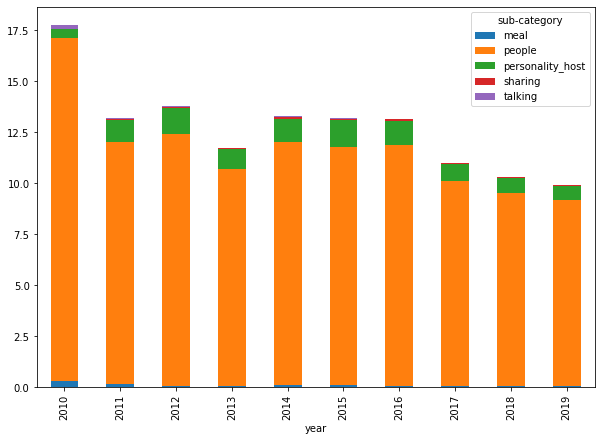

In [162]:
pivot_social.loc[:,['meal','people', 'personality_host', 'sharing', 'talking']].plot.bar(stacked=True, figsize=(10,7))
plot.title("kmp")

In [106]:
for2010 = adoptionForSetOfReviews('social', reviews, dictionary, '2010-01-01', '2011-01-01', k_social)
for2011 = adoptionForSetOfReviews('social', reviews, dictionary, '2011-01-01', '2012-01-01', k_social)
for2012 = adoptionForSetOfReviews('social', reviews, dictionary, '2012-01-01', '2013-01-01', k_social)
for2013 = adoptionForSetOfReviews('social', reviews, dictionary, '2013-01-01', '2014-01-01', k_social)
for2014 = adoptionForSetOfReviews('social', reviews, dictionary, '2014-01-01', '2015-01-01', k_social)
for2015 = adoptionForSetOfReviews('social', reviews, dictionary, '2015-01-01', '2016-01-01', k_social)
for2016 = adoptionForSetOfReviews('social', reviews, dictionary, '2016-01-01', '2017-01-01', k_social)
for2017 = adoptionForSetOfReviews('social', reviews, dictionary, '2017-01-01', '2018-01-01', k_social)
for2018 = adoptionForSetOfReviews('social', reviews, dictionary, '2018-01-01', '2019-01-01', k_social)
for2019 = adoptionForSetOfReviews('social', reviews, dictionary, '2019-01-01', '2020-01-01', k_social)

print("social")
print("2010 = ",for2010)
print("2011 = ",for2011)
print("2012 = ",for2012)
print("2013 = ",for2013)
print("2014 = ",for2014)
print("2015 = ",for2015)
print("2016 = ",for2016)
print("2017 = ",for2017)
print("2018 = ",for2018)
print("2019 = ",for2019)

social
2010 =  18.47190236038939
2011 =  13.570880643660214
2012 =  14.070011014104928
2013 =  11.613716016432903
2014 =  13.333055068321725
2015 =  13.067528234188126
2016 =  13.050876998943522
2017 =  11.056479028020762
2018 =  10.430184302446346
2019 =  10.008312913714395


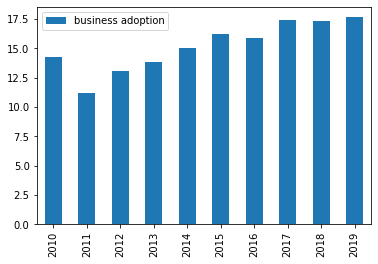

In [107]:
x_axis = [for2010b, for2011b, for2012b, for2013b, for2014b, for2015b, for2016b, for2017b, for2018b, for2019b]
df = pd.DataFrame(x_axis, index = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], columns = ['business adoption'])
df
df.plot.bar()

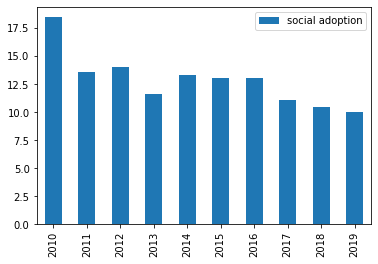

In [108]:
x_axis = [for2010, for2011, for2012, for2013, for2014, for2015, for2016, for2017, for2018, for2019]
df = pd.DataFrame(x_axis, index = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], columns = ['social adoption'])
df
df.plot.bar()